정형데이터 오염

In [1]:
import pandas as pd
df = pd.read_csv('Data/pollution.csv', index_col=0)
df.head()

,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [2]:
df.columns

Index(['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow',
       'rain'],
      dtype='object')

<Axes: >

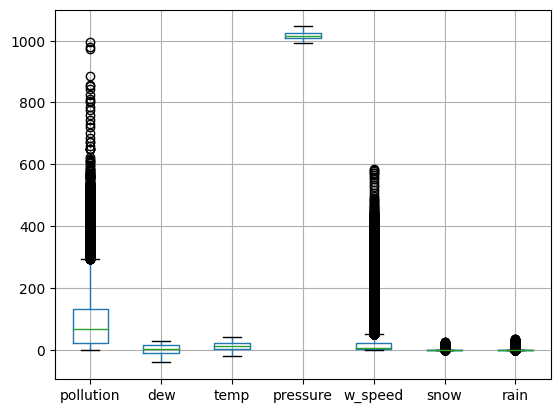

In [3]:
df.boxplot()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   pressure   43800 non-null  float64
 4   w_dir      43800 non-null  object 
 5   w_speed    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [5]:
df.values[:,4]

array(['SE', 'SE', 'SE', ..., 'NW', 'NW', 'NW'], dtype=object)

In [8]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

values = df.values
encoder = LabelEncoder()

# w_dr 변수 정수인코딩
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
np.unique(values[:,4])


array([0., 1., 2., 3.], dtype=float32)

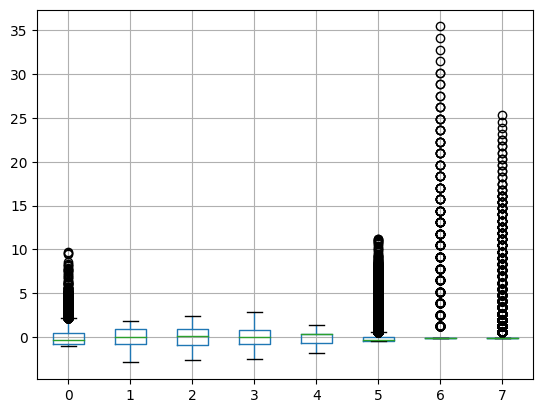

In [9]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
pd.DataFrame(scaled).boxplot()

plt.show()

In [10]:
real_data = scaled

In [11]:
real_data.shape

(43800, 8)

In [12]:
# parameters
d_input = real_data.shape[1]  # 변수개수
d_hidden = 32
d_output = 1 
g_input = 32
g_hidden = 32
g_output = d_input

In [13]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import numpy as np

# fake data
def makeZ(m, n):
    z = np.random.uniform(-1.0, 1.0, size=[m,n])
    return z

def myOptimizer(lr):
    return RMSprop(learning_rate = lr)

# 판별모델
def build_D():
    d_x = Input(batch_shape=(None, d_input))
    d_h = Dense(d_hidden, activation='relu')(d_x)
    d_o = Dense(d_output, activation='sigmoid')(d_h)

    d_model = Model(d_x, d_o)
    d_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.01))
    return d_model


In [14]:
from tensorflow.keras import backend as K

K.clear_session()
D = build_D()

In [15]:
D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 생성 모델
def build_G():
    g_x = Input(batch_shape=(None, g_input))    
    g_h = Dense(g_hidden, activation='relu')(g_x)
    g_o = Dense(g_output, activation='linear')(g_h)
    
    g_model = Model(g_x, g_o)
    
    return g_model
    
# GAN 모델
def build_GAN(discriminator, generator):
    discriminator.trainable = False
    z = Input(batch_shape=(None, g_input))
    Gz = generator(z)
    DGz = discriminator(Gz)
    
    gan_model = Model(z, DGz)
    gan_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.01))
    
    return gan_model



In [22]:
G = build_G()
G.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [23]:
GAN = build_GAN(D, G)
GAN.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32)]              0         
                                                                 
 model_3 (Functional)        (None, 8)                 1320      
                                                                 
 model (Functional)          (None, 1)                 321       
                                                                 
Total params: 1,641
Trainable params: 1,320
Non-trainable params: 321
_________________________________________________________________


In [24]:
n_batch_cnt = 5
n_batch_size = int(real_data.shape[0] / n_batch_cnt)
EPOCHS = 100

for epoch in range(EPOCHS):
    X = real_data[:]
    Z = makeZ(m=X.shape[0], n=g_input)
    Gz = G.predict(Z) # 가짜 데이터로부터 분포 생성
    
    # discriminator 학습 데이터 준비
    d_target = np.zeros(X.shape[0]*2)
    d_target[:X.shape[0]] = 1      # 진짜데이터 1
    d_target[X.shape[0]:] = 0      # 가짜데이터 0     
    bX_Gz = np.concatenate([X, Gz])
    
    # generator 학습 데이터 준비
    g_target = np.zeros(Z.shape[0])
    g_target[:] = 1
    
    # discriminator 학습        
    loss_D = D.train_on_batch(bX_Gz, d_target) # loss 계산
    
    # generator 학습        
    loss_G = GAN.train_on_batch(Z, g_target)
        
    if epoch % 10 == 0:
        print("Epoch: %d, D-loss = %.4f, G-loss = %.4f" %(epoch, loss_D, loss_G))



1369/1369 [==============================] - 2s 985us/step
Epoch: 0, D-loss = 0.7154, G-loss = 0.8304
1369/1369 [==============================] - 1s 962us/step
Epoch: 10, D-loss = 0.6179, G-loss = 0.8166
1369/1369 [==============================] - 1s 954us/step
Epoch: 20, D-loss = 0.7460, G-loss = 0.7903
1369/1369 [==============================] - 2s 1ms/step
Epoch: 30, D-loss = 0.6736, G-loss = 0.7837
1369/1369 [==============================] - 1s 1ms/step
Epoch: 40, D-loss = 0.6832, G-loss = 0.6927
1369/1369 [==============================] - 1s 1ms/step
Epoch: 50, D-loss = 0.6762, G-loss = 0.7265
1369/1369 [==============================] - 2s 1ms/step
Epoch: 60, D-loss = 0.6698, G-loss = 0.7205
1369/1369 [==============================] - 1s 1ms/step
Epoch: 70, D-loss = 0.6705, G-loss = 0.7381
1369/1369 [==============================] - 1s 1ms/step
Epoch: 80, D-loss = 0.6678, G-loss = 0.7346
1369/1369 [==============================] - 1s 985us/step
Epoch: 90, D-loss = 0.6697,

1369/1369 [==============================] - 1s 988us/step


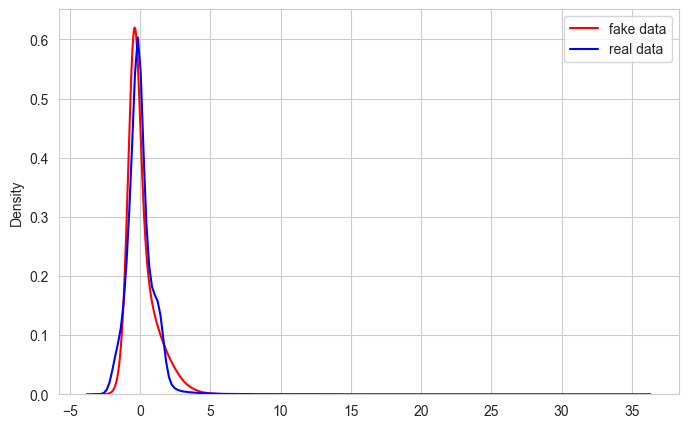

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# 학습 완료 후 데이터 분포 시각화
z = makeZ(m=real_data.shape[0], n=g_input)
fake_data = G.predict(z)

plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
sns.kdeplot(fake_data[:, 0], color='red', bw_method=0.3, label='fake data')
sns.kdeplot(real_data.reshape(-1,1)[:, 0], color='blue', bw_method=0.3, label='real data')
plt.legend()
plt.show()
#실제 데이터와 분포가 매우 유사함


In [26]:
# inverse
real = scaler.inverse_transform(real_data)
fake = scaler.inverse_transform(fake_data)

from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(real[:,3], fake[:,3]))   # 오차확인




14.81287

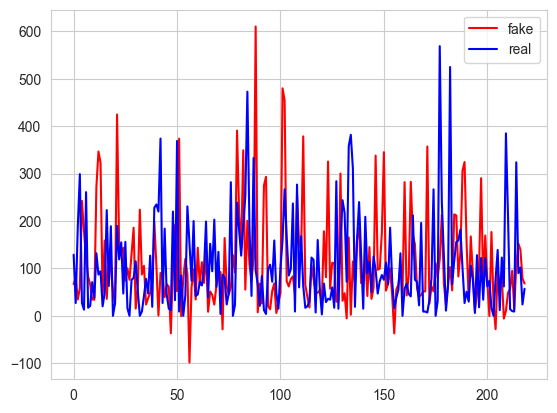

In [27]:
plt.plot(fake[::200,0], color='red', label='fake')
plt.plot(real[::200,0], color='blue', label='real')
plt.legend()
plt.show()

In [28]:
df2=pd.DataFrame(fake, columns=['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow','rain'])
df2.head()


,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
0,66.882164,-0.843669,13.824388,1018.123413,1.699415,45.613838,0.041659,-0.031932
1,231.154938,17.816427,20.670492,1004.655029,2.490164,12.367905,-0.022773,-0.038072
2,75.130852,1.420911,11.658473,1019.390564,2.080978,9.363623,-0.033318,-0.011800
3,71.827141,7.764647,16.566072,1006.095703,1.719805,10.485093,-0.035802,-0.055640
4,436.334747,0.792102,-7.526608,1025.262817,1.069463,10.606086,-0.038563,0.008126


In [29]:
df2.to_csv('Data/result/pollution_gan.csv',index=False)
